http://people.csail.mit.edu/moitra/docs/spectral.pdf

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from math import floor
import random
from algorithms import NMI
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from pyclustering.cluster.kmedians import kmedians
import seaborn as sns
import pandas as pd

%matplotlib inline

eigs = sp.sparse.linalg.eigs

In [2]:
def generate_graph(n, frac, p, q, **kwargs):
    
    if "random_state" in kwargs:
        seed = kwargs["random_state"]
        np.random.seed(seed)
    
    s1 = int(n*frac)
    s2 = n - s1
    g_in1 = p * np.ones((s1, s1))
    g_in2 = p * np.ones((s2, s2))
    g_out1 = q * np.ones((s1, s2))
    g_out2 = q * np.ones((s2, s1))

    block_model = np.bmat([[g_in1, g_out1], [g_out2, g_in2]])
    A = 1.0 * (np.random.rand(n, n) < block_model)
    true_comm = np.concatenate([ np.ones((s1, 1)), -np.ones((s2, 1))]).T

    cluster_1 = []
    cluster_2 = []
    for arg, node in enumerate(true_comm[0]):
        if node == 1:
            cluster_1.append(arg)
        else:
            cluster_2.append(arg)
    true_comm = [cluster_1, cluster_2]
    A = 1.0*((A.T + A) !=0)
    return block_model, A, true_comm

In [3]:
def projection(matrix, x, k):
    Lambda, U = eigs(1.0 * matrix.dot(matrix.T), k, which="LR")
    Lambda, U = np.real(Lambda), np.real(U)
    if np.any(Lambda < 0):
        # From paper:  in practice some of the eigenvalues of A may
        #              be negative; if that happens, we truncate them to 0
        U, Lambda = U[:, Lambda > 0], Lambda[Lambda > 0]
        k = np.count_nonzero(Lambda > 0)
        print('Some of Lambda < 0. Now I just remove it, new k={}'.format(k))

    
    return np.dot(np.dot(U, U.T), x)

In [4]:
def Clustering(graph, k=2, clustering_mode='kmeans', **kwargs):
    
    if type(graph) == nx.classes.graph.Graph:
        hat_G = nx.adjacency_matrix(G = graph).toarray()
        n_nodes = hat_G.shape[0]
    else:
        hat_G = graph
        n_nodes = graph.shape[0]
        
    permutation = np.random.permutation(n_nodes)
    first_part_of_nodes = permutation[: int(n_nodes/2)]
    second_part_of_nodes = permutation[int(n_nodes/2) :]
    A = hat_G[:,first_part_of_nodes]
    B = hat_G[:,second_part_of_nodes]
    
    hat_H = np.zeros((n_nodes, n_nodes))
    hat_H[:, first_part_of_nodes] = projection(matrix=B, x=A, k=k)
    hat_H[:, second_part_of_nodes] = projection(matrix=A, x=B, k=k)
    
    if clustering_mode == 'kmeans':
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
        ans = np.array(kmeans.fit_predict(hat_H))
    elif clustering_mode == 'kmedians':
        cc = hat_H[np.random.choice(hat_H.shape[0], k)]
        km = kmedians(hat_H, initial_centers=cc)
        km.process()
        ans = np.array(km.get_clusters())
        return ans
    else:
        raise ValueError('Unknown clustering_mode: ' + clustering_mode)
        
    T = []
    for i in range(ans.min(), ans.max()+1):
        T_i = []
        for ind, j in enumerate(ans):
            if j==i:
                T_i.append(ind)
        T.append(T_i)
    return T

In [5]:
def clustering_result(n=500, k=2, p=0.6, q=0.3, frac=0.5, n_iter=3):
    score = []
    for i in range(n_iter):
        block_model, A, true_comm = generate_graph(n=n, frac=frac, p=p, q=q)
        ans = Clustering(A, k)
        score.append(NMI.NMI(ans, true_comm))
    return (np.array(score).mean(), np.array(score).std())

In [6]:
def plot_nmi_p(n, p_array, q, frac, n_iter, ax=None):
    nmi = []
    std = []
    for p in p_array:
        score, std_score = clustering_result(n=n, k=2, p=p, q=q, frac=0.5, n_iter=n_iter)
        nmi.append(score)
        std.append(std_score)
    nmi = np.array(nmi)
    std = np.array(std)
    plt.figure(figsize=(15,10))
    ax.plot(p_array, nmi, color = "g", label = "q = {0}".format(q))
    ax.legend(loc="upper left")
    ax.fill_between(p_array, nmi+std, nmi-std, color="g", alpha=0.2)
    return ax

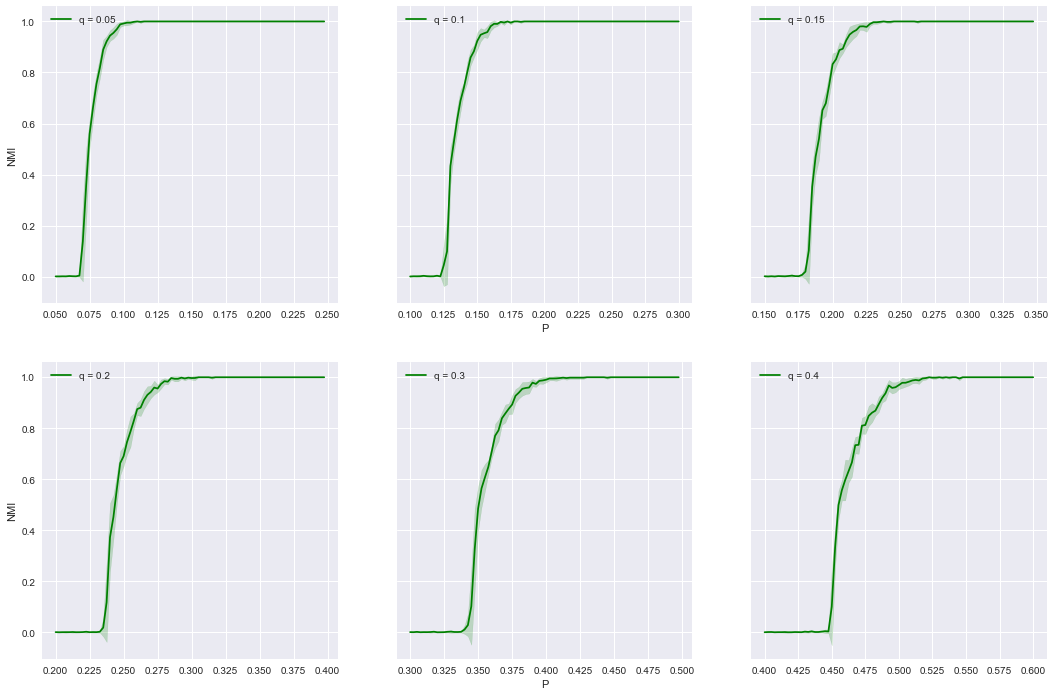

In [7]:
fig, axarr = plt.subplots(2, 3, sharey=True)
fig.set_figheight(12)
fig.set_figwidth(18)
qarr = [[0.05, 0.1, 0.15], [0.2, 0.3, 0.4]]
for arr_q, arr_ax in zip(axarr, qarr):
    for q, ax in zip(arr_ax, arr_q):
        plot_nmi_p(n=600, p_array=np.arange(q, q+0.2, 0.0025), q=q, frac=0.5, n_iter=10, ax=ax) 

axarr[0][0].set_ylabel(ylabel = "NMI")
axarr[1][0].set_ylabel(ylabel = "NMI")
axarr[0][1].set_xlabel(xlabel = "P")
axarr[1][1].set_xlabel(xlabel = "P")

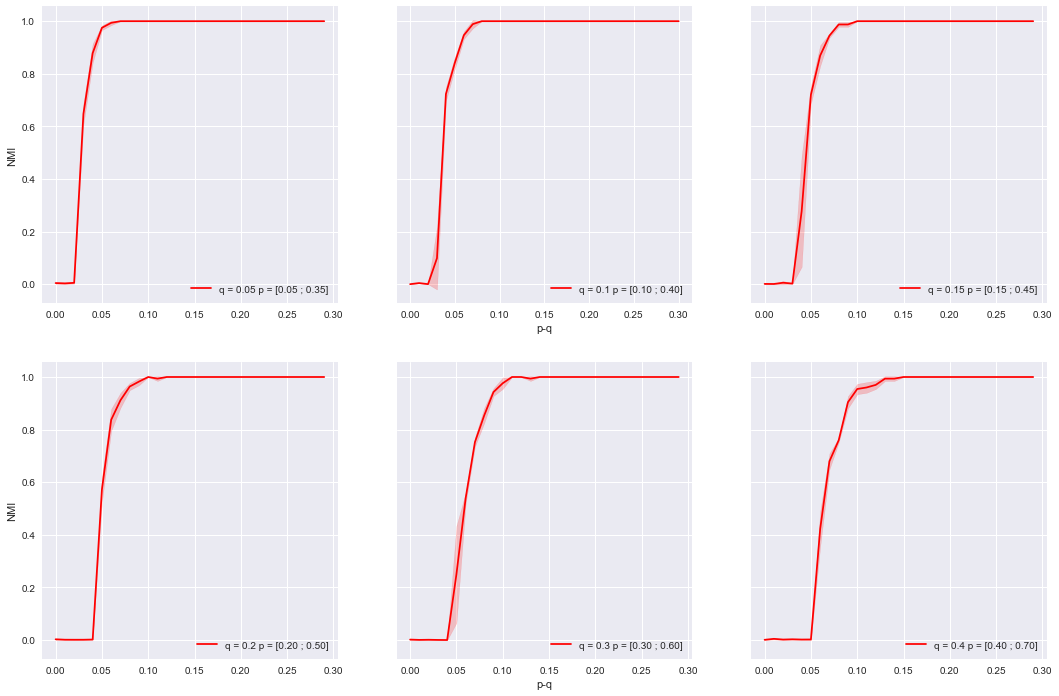

In [9]:
qarr = [[0.05, 0.1, 0.15], [0.2, 0.3, 0.4]]
fig, axarr = plt.subplots(2, 3, sharey=True)
fig.set_figheight(12)
fig.set_figwidth(18)

for arr_q, arr_x in zip(qarr, axarr):
    for q, ax in zip(arr_q, arr_x):
        nmi = []
        diff = []
        std = []
        for p in np.arange(q, q+0.3, 0.01):
            score, std_score = clustering_result(n=500, k=2, p=p, q=q, frac=0.5, n_iter=3)
            nmi.append(score)
            diff.append(p-q)
            std.append(std_score)
        ax.plot(diff, nmi, color = "r", label = "q = {0} p = [{1:.2f} ; {2:.2f}]".format(q, q, q+0.3))
        ax.fill_between(diff, np.array(nmi)-np.array(std), np.array(nmi)+np.array(std), color="r", alpha=0.2)
        ax.legend(loc="lower right")
axarr[0][0].set_ylabel(ylabel = "NMI")
axarr[1][0].set_ylabel(ylabel = "NMI")
axarr[0][1].set_xlabel(xlabel = "p-q")
axarr[1][1].set_xlabel(xlabel = "p-q")

In [7]:
from algorithms import NMF_clust, OCCAM, SAAC

In [10]:
def clustering_result_method(method, n=500, k=2, p=0.6, q=0.3, frac=0.5, n_iter=3):
    score = []
    for i in range(n_iter):
        block_model, A, true_comm = generate_graph(n=n, frac=frac, p=p, q=q)
        ans = method(A, k)
        score.append(NMI.NMI(ans, true_comm))
    return (np.array(score).mean(), np.array(score).std())

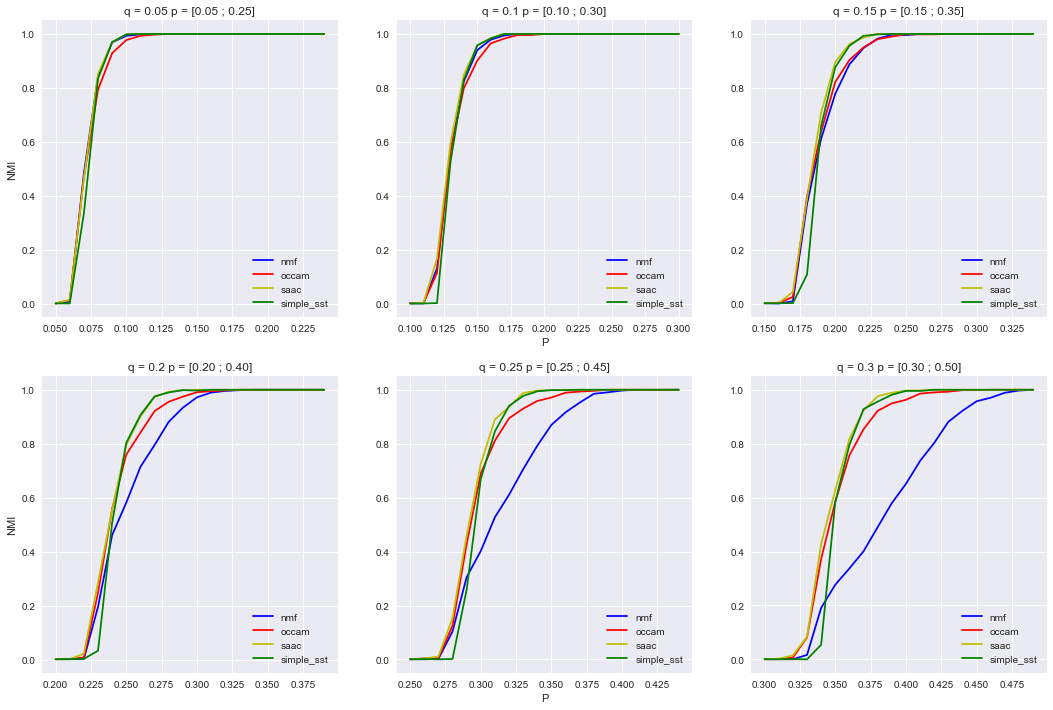

In [13]:
fig, axarr = plt.subplots(2, 3)
fig.set_figheight(12)
fig.set_figwidth(18)
q_array = [[0.05, 0.1, 0.15], [0.2, 0.25, 0.3]]

for arr_ax, arr_q in zip(axarr, q_array):
    for ax, q in zip(arr_ax, arr_q):
        p_array = np.arange(q, q+0.2, 0.01)
        nmf = []
        occam = []
        saac = []
        simple_sst = []
        
        for p in p_array:
            nmf_score, _ = clustering_result_method(method=NMF_clust.NMF_clust, n=700, k=2, p=p, q=q, frac=0.5, n_iter=10)
            occam_score, _ = clustering_result_method(method=OCCAM.OCCAM, n=700, k=2, p=p, q=q, frac=0.5, n_iter=10)
            saac_score, _ = clustering_result_method(method=SAAC.SAAC, n=700, k=2, p=p, q=q, frac=0.5, n_iter=10)
            simple_sst_score, _ = clustering_result_method(method=Clustering, n=700, k=2, p=p, q=q, frac=0.5, n_iter=10)

            nmf.append(nmf_score)
            occam.append(occam_score)
            saac.append(saac_score)
            simple_sst.append(simple_sst_score)

        ax.plot(p_array, nmf, color="b")
        ax.plot(p_array, occam, color = "r")
        ax.plot(p_array, saac, color = "y")
        ax.plot(p_array, simple_sst, color = 'g')
        ax.legend(["nmf", "occam", "saac", "simple_sst"], loc = "lower right")
        ax.set_title("q = {0} p = [{1:.2f} ; {2:.2f}]".format(q, q, q+0.2))
        
axarr[0][0].set_ylabel(ylabel = "NMI")
axarr[1][0].set_ylabel(ylabel = "NMI")
axarr[0][1].set_xlabel(xlabel = "P")
axarr[1][1].set_xlabel(xlabel = "P")